Recently, I am working into some [deep learning for genomics](https://gist.github.com/wckdouglas/a49a998b13b8bc4ffe2880cee6c738fb). My go-to deep-learning framework [Keras](http://keras.io) has a nice feature ```fit_generator``` that fetches mini-batches of data from a indefinite ```python generator``` and fit the model incrementally on each mini-batch. The ```python generator``` should yield a batch of feature and label from every ```next(generator)``` call. An example is as follow:

``` {python}
class data_generator():
    '''
    suppose the input data file is two columns:
    where first columns is feature, second column is label   
    '''

    def __init__(self, tsv_file, batch_size = 100):
        self.X = []
        self.y = []
        self.batch_size = batch_size
        self.data_file = tsv_file
        self.sample_generator = open(self.data_file)
        
    def __next__(self):
        # reinitiate samples
        self.X = []
        self.y = []
        
        # populate the batch feature and label
        data_gen()
        
        # return for keras model fit_generater
        return self.X, self.y
    
    def data_gen(self):
        sample_count = 0
        while self.batch_size > sample_count:  # break loop when batch is filled
            try:
                line = next(self.sample_generator)
                feature, label = line.split('\t') ## extract feature and labels from the two columns
                self.X.append(feature)
                self.y.append(label)
                sample_count += 1
            except StopIteration: # if it loops to the end, re-open the file and loop again
                self.sample_generator = open(self.data_file)  ## open the file again
                line = next(self.sample_generator)
                feature, label = line.split('\t')  ## extract feature and labels from the two columns
                self.X.append(feature)
                self.y.append(label)
                sample_count += 1
```

However, one drawback of this generator is batches are created sequentially from the data file, such that training samples are not shuffled. To introduce randomness into mini-batches, we can add a line of ```if random.random() > 0.5:``` before putting sample into the batch:

``` {python}
    def data_gen(self):
        sample_count = 0
        while self.batch_size > sample_count:  # break loop when batch is filled
            try:
                line = next(self.sample_generator)
                if random.random() > 0.5:  ### added randomness ###
                    feature, label = line.split('\t') ## extract feature and labels from the two columns
                    self.X.append(feature)
                    self.y.append(label)
                    sample_count += 1
            except StopIteration: # if it loops to the end, re-open the file and loop again
                self.sample_generator = open(self.data_file)  ## open the file again
                line = next(self.sample_generator)
                if random.random() > 0.5: ### added randomness ###
                    feature, label = line.split('\t')  ## extract feature and labels from the two columns
                    self.X.append(feature)
                    self.y.append(label)
                    sample_count += 1
```

The builtin ```random``` module in ```python``` is nice enough to generator a number between 0 and 1, but it can be a bit slow. So in this post, I will show an [implementation](https://stackoverflow.com/questions/16138090/correct-way-to-generate-random-numbers-in-cython?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa) of random float number between 0 and 1 using ```cython``` and see how much speed up we can get. 

Below is the ```cython``` random function:

In [19]:
%matplotlib inline
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [20]:
%%cython

from libc.stdlib cimport rand, RAND_MAX

cpdef double cy_random():
    return rand()/RAND_MAX

Let's check if the results are similar by looking at the distibution of 10000 random numbers:

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


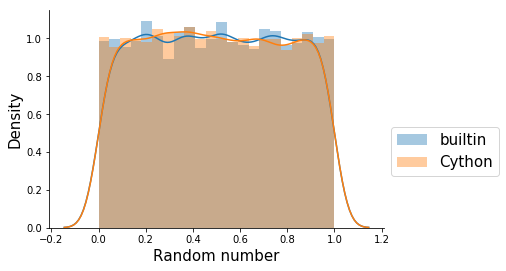

In [21]:
import random
import matplotlib.pyplot as plt
import seaborn as sns

ax = plt.subplot(111)
sns.distplot([random.random() for i in range(10000)], ax = ax, label='builtin')
sns.distplot([cy_random() for i in range(10000)], ax = ax, label = 'Cython')
ax.legend(fontsize=15, bbox_to_anchor = (1,0.5))
ax.set_xlabel('Random number', fontsize = 15)
ax.set_ylabel('Density', fontsize=15)
sns.despine()

That looks similar enough, both of them are more or less uniform over [0,1]. Now, lets see how much time it takes for each of them to run:

In [16]:
%timeit random.random()

108 ns ± 7.83 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [17]:
%timeit cy_random()

54.2 ns ± 2.73 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
